In [1]:
## import all necessary libraries ##

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#########################

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.objects.log.util import insert_classifier

#########################

import distance

from similarity.levenshtein import Levenshtein
levenshtein = Levenshtein()

from similarity.damerau import Damerau
damerau = Damerau()

from pyjarowinkler import distance as jwdistance
from similarity.jarowinkler import JaroWinkler
jarowinkler = JaroWinkler()

from similarity.weighted_levenshtein import WeightedLevenshtein
from similarity.weighted_levenshtein import CharacterSubstitutionInterface
import math
from random import sample
from random import seed
class CharacterSubstitution(CharacterSubstitutionInterface):
    def cost(self, c0, c1):
        return math.inf # assign inifte weight to all substitutions
levenshtein2 = WeightedLevenshtein(CharacterSubstitution())

#########################


# Distance class

In [2]:
class Distance:
    
    ### SETUP ###
    
    ## load dataset, generate mapping and generate strings
    def __init__(self, path):
        self.strings = []
        self.matrix = []
        self.transl = {}
        self.variant_to_Vindex = {}
        self.index_to_variant = []
        
        self.log = xes_importer.apply(path)
        
        try:
            # generate custom activity classifier
            self.log, activity_key = insert_classifier.insert_activity_classifier_attribute(self.log, "Activity classifier")
            for trace in self.log:
                for event in trace:
                    custom_classifier = ""
                    for activity_classifier in self.log.classifiers["Activity classifier"]:
                        custom_classifier = custom_classifier + event[activity_classifier] + "+"
                    custom_classifier = custom_classifier[:-1]
                    event["customClassifier"] = custom_classifier
        except:
            for trace in self.log:
                for event in trace:
                    event["customClassifier"] = event["concept:name"]
    
                

        seed(1633048)
        #self.log = sample(self.log, int(len(self.log)/10))
        self.clear_caches()
        
        self.gen_trace_to_Tindex()
        
        self.gen_mapping()
        self.gen_variant_strings()        
    
    def clear_caches(self):
        self.Nk_res_dict = {} # N_k result cache
    
    ## generate mapping from activity to char
    def gen_mapping(self):
        ## generate mapping from activities to chars ##
        # TODO read Activity Classifier for correct naming of activities
        #activities = list(attributes_filter.get_attribute_values(self.log, "concept:name").keys())
        activities = list(attributes_filter.get_attribute_values(self.log, "customClassifier").keys())
        #activities2 = list(attributes_filter.get_attribute_values(self.log, "lifecycle:transition").keys())
        #activities = [i + "-" + j for i, j in zip(activities2, activities2)]
        for i, a in enumerate(activities):
            self.transl[a] = chr(i+1)

    def gen_trace_to_Tindex(self):
        self.trace_to_Tindex = {}
        for i, t in enumerate(self.log):
            self.trace_to_Tindex[t] = i
            
            
    ## generate strings for all variants
    def gen_variant_strings(self):
        self.variants = variants_filter.get_variants(self.log, parameters={variants_filter.Parameters.ACTIVITY_KEY: "customClassifier"}) # all variants as dictionary
        variant_strings = list(self.variants.keys()) # variants as strings
        self.variant_to_index = {} # dictionary to translate variant to index in list for later lookup of traces
        
        for i, v in enumerate(variant_strings):
            string = ""
            for e in v.split(","):
                string = string + self.transl[e] 
            
            #self.strings.append(list_to_string(v.split(",")))
            self.strings.append(string)
            
            self.variant_to_index[v] = i
            self.index_to_variant.append(v)
            
        print("Number of variants: " + str(len(self.strings)))
    
    ### CALCULATION ###
    
    ## calculate distance matrix
    def calculate(self):
        n = len(self.strings)
        self.matrix = np.full((n, n), 0, dtype = np.uint8)

        for i, x in enumerate(self.strings):
            for j, y in enumerate(self.strings):
                if j >= i: # only calculate upper right triangle of matrix
                    #dist = distance.hamming(x, y)
                    dist = levenshtein.distance(x, y)
                    #dist = levenshtein2.distance(x, y)
                    #dist = damerau.distance(x, y)
                    #dist = (1- jarowinkler.similarity(x, y))*255
                    #print(dist)
                    self.matrix[i][j] = dist

        # mirror upper right triangle of matrix by adding the transposition
        self.matrix = self.matrix + self.matrix.T

        return self.matrix
    
    ### RETRIEVAL ###
    
    ## translate trace to its corresponding matrix index
    def trace_to_index(self, trace):
        # convert trace to string tion of variant (concept:name separated by commas)
        trace_string = ""
        for e in trace:
            #trace_string = trace_string + e["concept:name"] + ","
            trace_string = trace_string + e["customClassifier"] + ","
        trace_string = trace_string[:-1] # remove last comma

        return self.variant_to_index[trace_string]
    
    ## translate matrix (variant) index to trace indices
    def index_to_traces(self, i):
        variant_string = self.index_to_variant[i]
        traces = self.variants[variant_string] # retrieve traces from variant dictionary
        filtered_variants = {variant_string: traces} # generate new variants dictionary with only one variant
        
        filtered_log = variants_filter.apply(self.log, filtered_variants, parameters={variants_filter.Parameters.ACTIVITY_KEY: "customClassifier"})
        traces = []
        for t in filtered_log:
            traces.append(t)
        
        return traces
        
    
    ## retrieve distance of two traces from matrix
    def dist(self, t1, t2):
        i1 = self.trace_to_index(t1)
        i2 = self.trace_to_index(t2)
        return self.matrix[i1][i2]
    
    # return traces of k nearest neighbors of A
    def N_k(self, k, A):
        A_variant_index = self.trace_to_index(A)
        if A_variant_index in self.Nk_res_dict.keys(): # check result cache
            #print("N_k cache hit")
            return self.Nk_res_dict[A_variant_index]
        else:
            idx_sort = np.argsort(self.matrix[A_variant_index]) # indices of neighbors in ascending distance

            i = 0
            N_k_traces = []
            while len(N_k_traces) < k:
                N_k_traces.extend(self.index_to_traces(idx_sort[i]))
                if A in N_k_traces:
                    N_k_traces.remove(A)
                i = i + 1
                
            
            self.Nk_res_dict[A_variant_index] = N_k_traces
            return N_k_traces

# LOF class

In [3]:
class LOF:
    
    def __init__(self, path):
        self.dist = Distance(path)
        self.dist.calculate()
        self.clear_caches()
    
    def clear_caches(self):
        self.dist.clear_caches()
        
        # result caches
        self.kd_res_dict = {}
        self.rd_res_dict = {}
        self.lof_res_dict = {}
        self.lrd_res_dict = {}
    
    
    ## k-distance
    def k_distance(self, k, A):
        A_variant_index = self.dist.trace_to_index(A)
        if A_variant_index in self.kd_res_dict.keys(): # check result cache
            #print("k_distance cache hit")
            return self.kd_res_dict[A_variant_index]
        else:
            N_k = self.dist.N_k(k, A)
            k_variant_index = self.dist.trace_to_index(N_k[-1])
            A_variant_index = self.dist.trace_to_index(A)

            res = self.dist.matrix[A_variant_index][k_variant_index] # retrieve distance from k-th nearest neighbor (-1 to offset arraystart, +1 to not include trace itself)
            self.kd_res_dict[A_variant_index] = res
            return res
        
    ## reachability distance
    def reachability_dist(self, k, A, B):
        A_variant_index = self.dist.trace_to_index(A)
        B_variant_index = self.dist.trace_to_index(B)
        if (A_variant_index, B_variant_index) in self.rd_res_dict.keys(): # check result cache
            #print("rd cache hit")
            return self.rd_res_dict[(A_variant_index, B_variant_index)]
        else:
            res = max(self.k_distance(k, B), self.dist.matrix[A_variant_index][B_variant_index])
            self.rd_res_dict[(A_variant_index, B_variant_index)] = res
            return res
    
    ## local reachability density
    def lrd(self, k, A):
        A_variant_index = self.dist.trace_to_index(A)
        if A_variant_index in self.lrd_res_dict.keys(): # check result cache
            #print("lrd cache hit")
            return self.lrd_res_dict[A_variant_index]
        else:
            
            N_k = self.dist.N_k(k, A)            
            sum = 0
            for b in N_k:
                   sum = sum + self.reachability_dist(k, A, b) # sum of rachability distances in k-Neighborhood
            
            res = 1 / (sum / len(N_k))
            self.lrd_res_dict[A_variant_index] = res
            return res
        
    def lof(self, k, A):
        A_variant_index = self.dist.trace_to_index(A)
        if A_variant_index in self.lof_res_dict.keys(): # check result cache
            #print("lof cache hit")
            return self.lof_res_dict[A_variant_index]
        else:
            
            N_k = self.dist.N_k(k, A)
            sum = 0
            for b in N_k:
                sum = sum + self.lrd(k, b)

            res = sum / (len(N_k) * self.lrd(k, A))
            self.lof_res_dict[A_variant_index] = res
            return res
    
    def calculate(self, k):
        res = np.array([])
        for a in self.dist.log:
            res = np.append(res, self.lof(k, a))
            
        return res
    

# Run

In [6]:
start = datetime.now()
print(start)

path = "Datasets/BPIC20.xes"
lof = LOF(path)

end = datetime.now()
print(end-start)

2021-05-07 00:36:34.196744


parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

Number of variants: 1478
0:02:33.801302


In [7]:
start = datetime.now()
print(start)

k = len(max(lof.dist.variants.values(), key=len)) + 1 # no. traces in largest variant + 1
lof.clear_caches()
print(k)
#print(lof.lof(k, lof.dist.log[0]))
res = lof.calculate(k)

end = datetime.now()
print(end-start)

2021-05-07 00:39:54.780743
957


KeyboardInterrupt: 

# Analysis of results

In [8]:
for t in range(10):
    t_string = ""
    for e in lof.dist.log[t]:
        t_string = t_string + e["concept:name"] + " " + e["lifecycle:transition"] + ","
        #t_string = t_string + e["concept:name"] + ","
    t_string = t_string[:-1]

    
    print(str(round(res[t], 3)) + "\t" + t_string)

1.303	Queued Awaiting Assignment,Accepted In Progress,Accepted Assigned,Accepted In Progress,Completed Closed
1.552	Accepted In Progress,Accepted In Progress,Accepted Wait,Accepted In Progress,Accepted In Progress,Completed Closed
1.32	Accepted In Progress,Accepted Wait,Accepted In Progress,Accepted In Progress,Completed Closed
1.32	Accepted In Progress,Accepted Wait,Accepted In Progress,Accepted In Progress,Completed Closed
1.273	Accepted In Progress,Accepted Wait,Queued Awaiting Assignment,Accepted In Progress,Accepted Assigned,Accepted In Progress,Completed Closed
1.768	Accepted In Progress,Accepted In Progress,Accepted Wait,Accepted In Progress,Accepted In Progress,Accepted In Progress,Completed Closed
1.273	Accepted In Progress,Accepted Wait,Queued Awaiting Assignment,Accepted In Progress,Accepted Assigned,Accepted In Progress,Completed Closed
1.38	Accepted In Progress,Accepted In Progress,Accepted In Progress,Queued Awaiting Assignment,Accepted In Progress,Queued Awaiting Assignm

In [9]:
print(np.mean(res))
print(np.std(res))
print(np.percentile(res, 95))

1.266755507750122
0.4969746225442282
2.076714912403354


(array([922., 196., 111., 136.,  29.,  26.,  22.,   9.,  12.,   6.,   4.,
          1.,   2.,   2.,   4.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.97686069, 1.17006461, 1.36326852, 1.55647244, 1.74967635,
        1.94288027, 2.13608418, 2.3292881 , 2.52249202, 2.71569593,
        2.90889985, 3.10210376, 3.29530768, 3.48851159, 3.68171551,
        3.87491942, 4.06812334, 4.26132725, 4.45453117, 4.64773509,
        4.840939  , 5.03414292, 5.22734683, 5.42055075, 5.61375466,
        5.80695858, 6.00016249, 6.19336641, 6.38657032, 6.57977424,
        6.77297815, 6.96618207, 7.15938599, 7.3525899 , 7.54579382,
        7.73899773, 7.93220165, 8.12540556, 8.31860948, 8.51181339,
        8.70501731]),
 <BarContainer object of 40 artists>)

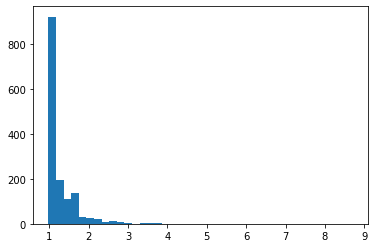

In [222]:
plt.hist(res, 40)

## Classification

In [12]:
anomaly = np.empty(len(res), dtype = bool)
cutoff = np.percentile(res, 95) # 5% with largest LOF are classified as anomalies

for i, a in enumerate(res):
    anomaly[i] = (a >= cutoff)

## Exporting results

In [13]:
np.savetxt(path+ ".csv", res, delimiter=";", fmt='%1.8f')

## Correlation of LOF with process metric

In [195]:
lengths = []
e_types = []
case_durations = case_statistics.get_all_casedurations(lof.dist.log, parameters={case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})

for i, t in enumerate(lof.dist.log):
    concept_names = set()
    for e in t:
        #concept_names.add(e["concept:name"]+ "+" + e["lifecycle:transition"])
        concept_names.add(e["concept:name"])
    e_types.append(len(concept_names))
    lengths.append(len(t))

[[1.         0.54545301]
 [0.54545301 1.        ]]


Text(0, 0.5, 'LOF')

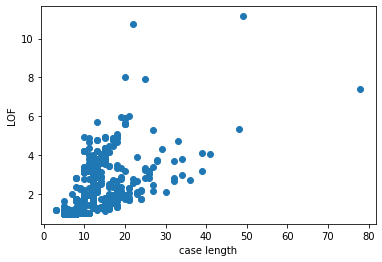

In [196]:
# LOF vs case lengths

print(np.corrcoef(lengths, res))
plt.scatter(lengths, res)
plt.xlabel("case length")
plt.ylabel("LOF")

[[1.         0.45224782]
 [0.45224782 1.        ]]


Text(0, 0.5, 'LOF')

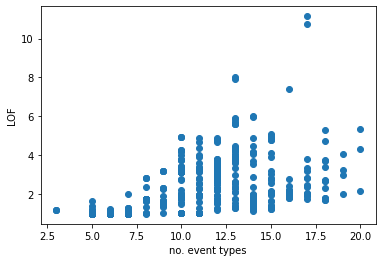

In [197]:
# LOF vs no. activities

print(np.corrcoef(e_types, res))
plt.scatter(e_types, res)
plt.xlabel("no. event types")
plt.ylabel("LOF")

[[1.         0.02621834]
 [0.02621834 1.        ]]


Text(0, 0.5, 'LOF')

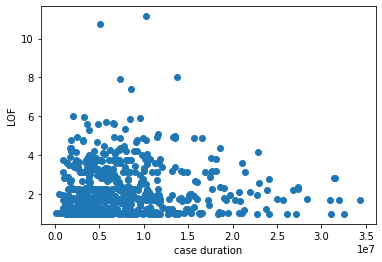

In [198]:
# LOF vs. case duration

print(np.corrcoef(np.array(case_durations), res))
plt.scatter(case_durations, res)
plt.xlabel("case duration")
plt.ylabel("LOF")

## Combination of process metrics

Text(0, 0.5, 'no. event types')

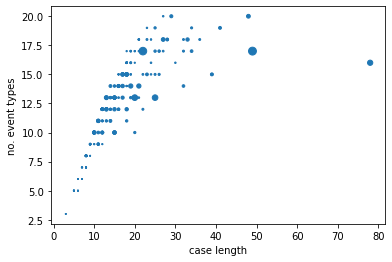

In [199]:
# Case lenghts + no. activities

plt.scatter(lengths, e_types, s = (res**2)*2, marker = ".")
plt.xlabel("case length")
plt.ylabel("no. event types")

Text(0, 0.5, 'case duration')

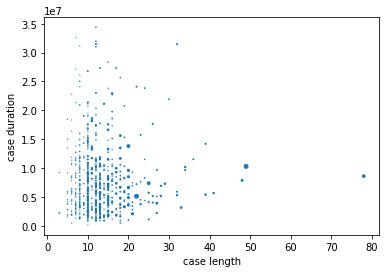

In [200]:
# Case lenghts + case durations

plt.scatter(lengths, case_durations, s = (res**2)*0.5, marker = ".")
plt.xlabel("case length")
plt.ylabel("case duration")

Text(0, 0.5, 'case duration')

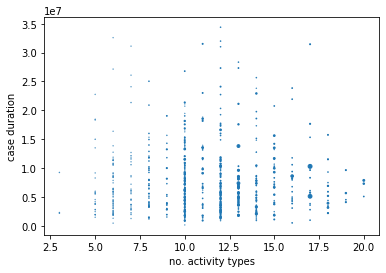

In [201]:
# Case lenghts + case durations

plt.scatter(e_types, case_durations, s = (res**2)*0.5, marker = ".")
plt.xlabel("no. activity types")
plt.ylabel("case duration")

In [213]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
